In [1]:
import sys
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.models import resnet18
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor

import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set_style("darkgrid")

%matplotlib inline

In [2]:
sys.path.append("../..")

from batteries import t2d, seed_all
from batteries.layers import CosFace

In [3]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using '{device}'!")

Using 'cuda:0'!


In [4]:
def get_transforms(dataset: str):
    """Get transforms depends from dataset.
    Args:
        dataset (str): dataset type (train or valid)
    Returns:
        dataset transforms
    """
    return Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])


def get_loaders(stage: str) -> tuple:
    """Loaders for a stage.
    Args:
        stage (str): stage name
    Returns:
        training and validation loader
    """
    trainset = MNIST(
        "./data", train=False, download=True, transform=get_transforms("train"),
    )
    testset = MNIST(
        "./data", train=False, download=True, transform=get_transforms("valid"),
    )
    train = DataLoader(
        trainset,
        batch_size=64,
        shuffle=True,
        num_workers=1,
        worker_init_fn=seed_all
    )
    valid = DataLoader(
        testset,
        batch_size=64,
        shuffle=False,
        num_workers=1
    )
    return train, valid

In [5]:
class SimpleNet(nn.Module):
    def __init__(self, n_classes: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

class EncoderWithHead(nn.Module):
    def __init__(self, encoder: nn.Module, head: nn.Module):
        super().__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, images, targets=None):
        features = self.encoder(images)
        if targets is None:
            return features
        outputs = self.head(features, targets)
        return outputs

In [6]:
seed_all(2020)

embedding_dim = 2
num_classes = 10

model = EncoderWithHead(
    encoder=SimpleNet(n_classes=embedding_dim),
    head=CosFace(embedding_dim, num_classes),
)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

In [7]:
train_loader, valid_loader = get_loaders("")
n_epochs = 50
for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = []
    for batch in train_loader:
        x, y = t2d(batch, device)
        output = model(x, y)
        loss = criterion(output, y)
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = np.mean(train_loss)
    model.eval()
    valid_loss = []
    accuracy = []
    with torch.no_grad():
        for batch in valid_loader:
            x, y = t2d(batch, device)
            output = model(x, y)
            loss = criterion(output, y)
            torch.argmax(output)
            valid_loss.append(loss.item())
            acc = (torch.argmax(output, -1) == y).sum().detach().item()
            acc /= y.size(0)
            accuracy.append(acc)
    valid_loss = np.mean(valid_loss)
    accuracy = np.mean(accuracy)
    print(f"Epoch {epoch}/{n_epochs}: train - {train_loss:.5f}, valid - {valid_loss:.5f} (accuracy - {accuracy:.5f})")

Epoch 1/50: train - 27.16165, valid - 22.43618 (accuracy - 0.04070)
Epoch 2/50: train - 20.97639, valid - 19.98423 (accuracy - 0.15645)
Epoch 3/50: train - 19.79499, valid - 19.46498 (accuracy - 0.17038)
Epoch 4/50: train - 18.53401, valid - 17.48343 (accuracy - 0.26971)
Epoch 5/50: train - 16.60626, valid - 15.25645 (accuracy - 0.34922)
Epoch 6/50: train - 15.63829, valid - 14.96210 (accuracy - 0.36057)
Epoch 7/50: train - 14.74813, valid - 14.08541 (accuracy - 0.37540)
Epoch 8/50: train - 20.86693, valid - 18.00984 (accuracy - 0.22661)
Epoch 9/50: train - 16.83283, valid - 15.27316 (accuracy - 0.35768)
Epoch 10/50: train - 15.31014, valid - 15.09364 (accuracy - 0.36973)
Epoch 11/50: train - 14.99006, valid - 13.66132 (accuracy - 0.37052)
Epoch 12/50: train - 16.69693, valid - 14.19933 (accuracy - 0.36286)
Epoch 13/50: train - 13.66779, valid - 12.42403 (accuracy - 0.42745)
Epoch 14/50: train - 12.28178, valid - 11.36065 (accuracy - 0.37928)
Epoch 15/50: train - 11.45131, valid - 11.6

In [8]:
valid_set = MNIST(
    "./data",
    train=False,
    download=True,
    transform=get_transforms("valid"),
)
valid_loader = DataLoader(
    valid_set,
    batch_size=64,
    shuffle=False,
    num_workers=1
)

model.eval()
embeddigs, labels = [], []
with torch.no_grad():
    for batch in valid_loader:
        x, y = t2d(batch, device)
        output = F.normalize(model(x))
        output = output.detach().cpu().numpy()
        embeddigs.append(output)
        labels.append(y.detach().cpu().numpy())

embeddigs = np.concatenate(embeddigs)
labels = np.concatenate(labels)

embeddigs.shape, labels.shape

((10000, 2), (10000,))

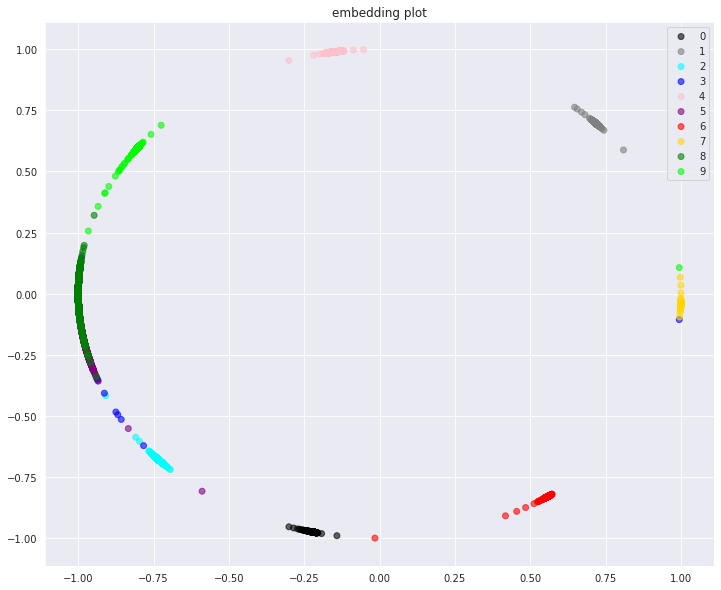

In [9]:
plt.figure(figsize=(12, 10))
color_map = {
    0: "black", 1: "grey", 2: "aqua", 3: "blue", 4: "pink",
    5: "purple", 6: "red", 7: "gold", 8: "green", 9: "lime",
}
for c in range(10):
    _map = labels == c
    plt.scatter(
        embeddigs[_map, 0], embeddigs[_map, 1],
        c=[color_map[item] for item in labels[_map]],
        alpha=0.6
    )
plt.legend(labels=[str(i) for i in range(10)])
plt.title("embedding plot");